# Clean CDEC Data and Save to Pickle

In [8]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import datetime
import pickle
from astropy.time import Time
from rasterio.plot import show
import rasterio as rio
from rasterio import features

In [56]:
pd.set_option('display.max_columns', None)

In [21]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

## Load CDEC Snow Depth for same date range and add to time series  
-> Only run this once, then load the pickle file to avoid redundancy

#### To Do: Check out SNOTEL access API - they have CDEC sites too!

In [3]:
tum = pd.read_csv('../data/CDEC/TUM_18.csv')
dan = pd.read_csv('../data/CDEC/DAN_18.csv')

tum = tum.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})
dan = dan.rename(columns={'OBS DATE':'OBS_DATE', 'DATE TIME':'DATE_TIME'})

In [4]:
tum_elev = 2621.28
dan_elev = 2965

In [5]:
# from stack overflow

from datetime import date


def int2date(argdate: int) -> date:
    """
    If you have date as an integer, use this method to obtain a datetime.date object.

    Parameters
    ----------
    argdate : int
      Date as a regular integer value (example: 20160618)

    Returns
    -------
    dateandtime.date
      A date object which corresponds to the given value `argdate`.
    """
    year = int(argdate / 10000)
    month = int((argdate % 10000) / 100)
    day = int(argdate % 100)

    return date(year, month, day)

#### Fill in Nan values so OBS_DATE can be converted to DateTimeIndex  
I found the locations where this column was Nan, and then used the dates on either side to fill in.

In [6]:
tum.loc[126, 'OBS_DATE'] = 20190204.0
tum.loc[134, 'OBS_DATE'] = 20190212.0
tum.loc[394, 'OBS_DATE'] = 20191030.0

#### Convert snow depth from inches to meters, convert time to datetime index, add doy

In [11]:
snwd = pd.DataFrame([tum.OBS_DATE, tum.VALUE]).transpose()
snwd.VALUE = snwd.VALUE * 2.54/100
snwd = snwd.rename(columns={'VALUE':'tum_m'})
snwd['dan_m'] = dan.VALUE * 2.54/100

snwd['Date'] = snwd['OBS_DATE'].map(lambda x: int(x))
snwd['Date'] = pd.DatetimeIndex(snwd['Date'].map(lambda x: int2date(x)))

snwd = snwd.set_index('Date')
snwd.sort_index(inplace=True)
snwd = snwd.drop(columns=['OBS_DATE'])
add_dowy(snwd)

Adding Day of Water Year (DOWY)


In [54]:
#snwd = snwd[snwd['tum_m'] < 2.9]

In [12]:
snwd.head(2)

,tum_m,dan_m,doy,decyear,dowy
Date,,,,,
2018-10-01,0.0254,-0.0508,274,2018.747945,1
2018-10-02,0.0000,NaN,275,2018.750685,2


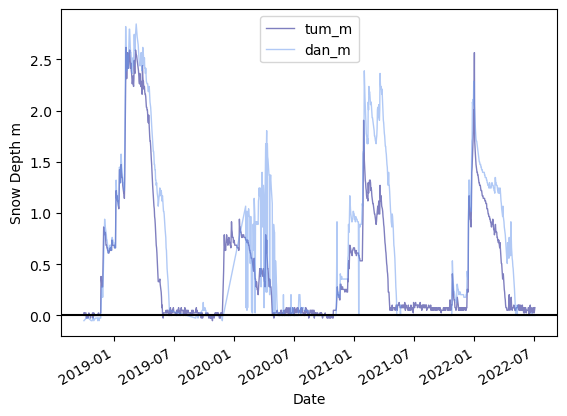

In [14]:
fig, ax = plt.subplots()
snwd['tum_m'][snwd['tum_m'] < 2.9].plot(alpha=0.5, color='navy', lw=1)
snwd['dan_m'][snwd['dan_m'] < 2.9].plot(alpha=0.5, color='cornflowerblue', lw=1)
ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')
plt.legend()

In [51]:
# Save the combined geodataframe of the two cdec sites

out_fn = '../data/CDEC/cdec_gdf.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(snwd, f)

## Create GDF of CDEC Coordinates and Radius 

In [77]:
tum_elev = 2621.28
dan_elev = 2965

tum_coords = [37.873000,-119.350000]
dan_coords = [37.897000,-119.257000]

tum_band = [2371.28, 2871.28]
dan_band = [2715,3215]

In [78]:
dan_elev - 250

2715

### Create 5 km radius around TUM CDEC site

In [92]:
# Create a transform that will go from the native ICESat-2 and Snotel CS (4326) to the common projection we will use (32610, ie UTM Zone 10 N)

target_crs = "EPSG:32611"
from pyproj import Transformer,CRS
to_target_crs = Transformer.from_crs(4326,target_crs)

In [93]:
# Transform the snotel site locations to 32610
# Originally written by Hannah for Methow notebook

points_cdec = []
cdec_coords = [(37.873000,-119.350000,2621.28),(37.897000,-119.257000,2965)]
for pt in to_target_crs.itransform(cdec_coords):
    points_cdec.append(pt)
x_cdec = [x_tuple[0] for x_tuple in points_cdec]
y_cdec = [y_tuple[1] for y_tuple in points_cdec]
z_cdec = [z_tuple[2] for z_tuple in points_cdec]
cdec_gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x_cdec, y_cdec), crs='epsg:32611')
cdec_gdf['elevation_m'] = z_cdec

<AxesSubplot: >

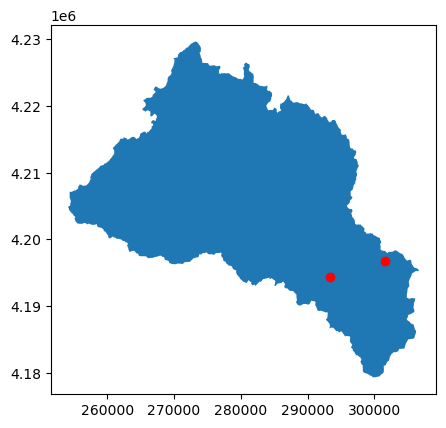

In [94]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')

In [95]:
cdec_gdf['site'] = ''
cdec_gdf.loc[0, 'site'] = 'tum'
cdec_gdf.loc[1, 'site'] = 'dan'
cdec_gdf

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan


In [96]:
from shapely.geometry import Point

tum = Point((cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.x, cdec_gdf[cdec_gdf['site'] == 'tum'].geometry.y))
dan = Point((cdec_gdf[cdec_gdf['site'] == 'dan'].geometry.x, cdec_gdf[cdec_gdf['site'] == 'dan'].geometry.y))

In [97]:
df_center= pd.DataFrame({'site':'tum_5km','geometry':[tum]})
df_center.loc[len(df_center)]={'site':'dan_5km', 'geometry':dan}
df_center

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/pandas/core/construction.py:810: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  subarr = construct_1d_object_array_from_listlike(arr)


,site,geometry
0,tum_5km,POINT (293306.5622950811 4194327.334556827)
1,dan_5km,POINT (301551.8767049168 4196788.618859532)


In [98]:
gdf_center = gpd.GeoDataFrame(df_center, geometry=df_center['geometry'], crs='epsg:32611')
gdf_center['geometry'] = gdf_center.geometry.buffer(5000)
gdf_center

,site,geometry
0,tum_5km,"POLYGON ((298306.562 4194327.335, 298282.486 4..."
1,dan_5km,"POLYGON ((306551.877 4196788.619, 306527.800 4..."


<AxesSubplot: >

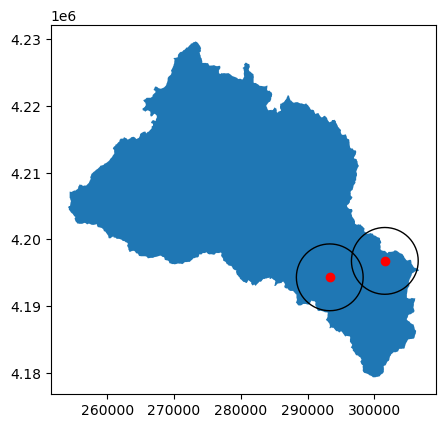

In [99]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_gdf.plot(ax=ax, c='r')
gdf_center.plot(ax=ax, facecolor='none')

## Combine the geodataframes

In [100]:
cdec_geom = pd.concat([cdec_gdf, gdf_center], ignore_index=True)
cdec_geom

,geometry,elevation_m,site
0,POINT (293306.562 4194327.335),2621.28,tum
1,POINT (301551.877 4196788.619),2965.00,dan
2,"POLYGON ((298306.562 4194327.335, 298282.486 4...",NaN,tum_5km
3,"POLYGON ((306551.877 4196788.619, 306527.800 4...",NaN,dan_5km


<AxesSubplot: >

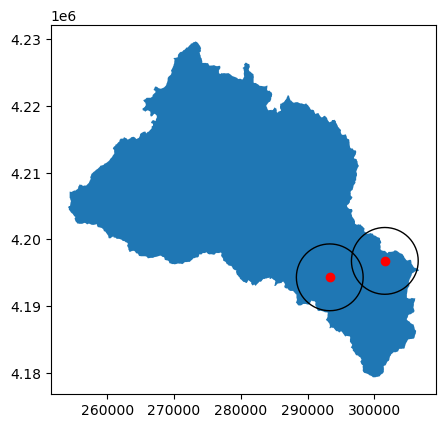

In [101]:
fig, ax = plt.subplots()

outline_gdf.plot(ax=ax)
cdec_geom[cdec_geom.geometry.geom_type == 'Point'].plot(ax=ax, color='r')
cdec_geom[cdec_geom.geometry.geom_type == 'Polygon'].plot(ax=ax, facecolor='none', edgecolor='k')
# cdec_gdf.plot(ax=ax, c='r')
# gdf_center.plot(ax=ax, facecolor='none')

In [102]:
cdec_geom.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Save the radius geodataframes

In [103]:
cdec_out_fn = '../data/CDEC/cdec_geometries.pkl'

with open(cdec_out_fn, 'wb') as f:
    pickle.dump(cdec_geom, f)

## Clean the Tuolumne Outline file

In [34]:
outline_gdf = gpd.read_file('../data/UpperTuolRiverBasinOutline.geojson')
outline_gdf = outline_gdf[0:1]
outline_gdf = outline_gdf.to_crs('EPSG:32611')

outline_fn = '../../data/site_outlines/tuolumne_outline_32611'

with open(outline_fn, 'wb') as f:
    pickle.dump(outline_gdf, f)

# Clip Lakes to Tuolumne 

In [35]:
outline_gdf = pickle.load(open('../../data/site_outlines/tuolumne_outline_32611', 'rb'))

In [27]:
lakes = gpd.read_file('../../data/site_outlines/California_Lakes.geojson')

In [29]:
lakes = lakes.to_crs('EPSG:32611')

In [36]:
lakes = gpd.clip(lakes, outline_gdf)

/Users/Hannah/opt/miniconda3/envs/analysis_2022/lib/python3.8/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

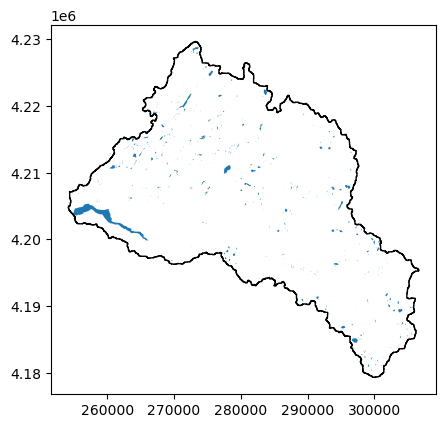

In [37]:
fig, ax = plt.subplots()

lakes.plot(ax=ax)
outline_gdf.plot(ax=ax, facecolor='none')

In [38]:
out_fn = '../../data/site_outlines/lakes_tuolumne.pkl'

with open(out_fn, 'wb') as f:
    pickle.dump(lakes, f)

# Create ASO GDF with Temporal Data for Plotting

## Clip and save all ASO snow-on files to study area

In [39]:
aso_dir = '../../data/lidar/tuolumne/snow_on/coarse_20m'
aso_fn_list = !ls $aso_dir/ASO*.tif
aso_fn_list

['../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190705_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20200507_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220228_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220429_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220518_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdep

In [40]:
len(aso_fn_list)

14

In [41]:
#aso_fn_list.pop(-1)

'../../data/lidar/tuolumne/snow_on/raw/ASO_Tuolumne_snowdepth_3m_20210429.tif'

In [41]:
aso_fn_list

['../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190324_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190417_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190503_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_3M_SD_USCATE_20190705_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20200507_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220204_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220228_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220405_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220429_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdepth_3m_20220518_20m.tif',
 '../../data/lidar/tuolumne/snow_on/coarse_20m/ASO_Tuolumne_Mosaic_snowdep

In [42]:
# Code adapted from David Shean's code, from Grand Mesa analysis presumably

aso_feat_list = []
ovr_scale = 8
dt_fieldnum = -2
for fn in aso_fn_list:
    src = rio.open(fn)
    a = src.read(1, masked=True, out_shape=(src.count, int(src.height / ovr_scale), int(src.width / ovr_scale)))
    ovr_transform = src.transform * src.transform.scale(src.width / a.shape[-1], src.height / a.shape[-2])
    mask = np.ma.getmaskarray(a).astype(np.uint8) - 1
    shapes = features.shapes(mask, mask=mask, transform=ovr_transform)
    geom_list = list(shapes)
    dt = os.path.splitext(os.path.split(fn)[-1])[0].split('_')[dt_fieldnum]
    aso_feat_list.extend([{'properties':{'fn':fn, 'date':dt}, 'geometry':i[0]} for i in geom_list])

In [43]:
aso_gdf = gpd.GeoDataFrame.from_features(aso_feat_list, crs=src.crs)
#aso_gdf = aso_gdf.to_crs(crs)

In [44]:
aso_gdf.tail(2)

,geometry,fn,date
20,"POLYGON ((242718.000 4234845.000, 242718.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,20200522
21,"POLYGON ((212352.000 4234641.000, 212352.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,20210429


In [45]:
area_thresh = 1e8
aso_gdf = aso_gdf.loc[aso_gdf.area > area_thresh]

In [46]:
aso_gdf['date'] = pd.to_datetime(aso_gdf['date'])

In [47]:
aso_gdf['platform'] = 'ASO'

In [48]:
add_dowy(aso_gdf, col='date')
aso_gdf.set_index('date', inplace=True)
aso_gdf['acqdate'] = aso_gdf.index.date

Adding Day of Water Year (DOWY)


In [49]:
aso_gdf['site'] = 'tuolumne'

In [57]:
aso_gdf.head()

,geometry,fn,platform,doy,decyear,dowy,acqdate,site
date,,,,,,,,
2019-03-24,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,83,2019.224658,175,2019-03-24,tuolumne
2019-04-17,"POLYGON ((254726.111 4234848.000, 259690.704 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,107,2019.290411,199,2019-04-17,tuolumne
2019-05-03,"POLYGON ((254726.111 4234848.000, 259690.704 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,123,2019.334247,215,2019-05-03,tuolumne
2019-07-05,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,186,2019.506849,278,2019-07-05,tuolumne
2020-05-07,"POLYGON ((242715.000 4234848.000, 242715.000 4...",../../data/lidar/tuolumne/snow_on/coarse_20m/A...,ASO,128,2020.346995,220,2020-05-07,tuolumne


In [55]:
aso_gdf.index.is_unique

True

In [59]:
aso_gdf.fn.dtype

dtype('O')

In [51]:
aso_fn = '../../data/aso_dates.pkl'

with open(aso_fn, 'wb') as f:
    pickle.dump(aso_gdf, f)

In [464]:
# save aso date information to a geojson for use in other notebooks

# aso_gdf_tosave.index = aso_gdf_tosave.index.astype(str)
# aso_gdf_tosave['acqdate'] = aso_gdf_tosave['acqdate'].astype(str)
# aso_gdf.to_file('../../data/aso_dates.geojson', driver='GeoJSON')

### Test how different my original snow off DEM is from the newer 2019 DEM

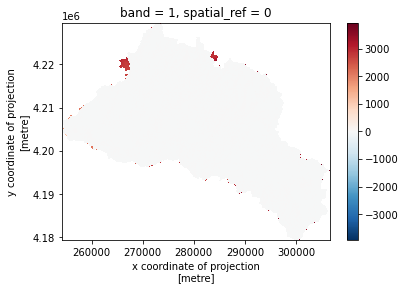

In [159]:
# Code from https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/
# from shapely.geometry import mapping

# lidar_pre_arr = rxr.open_rasterio(lidar_fn, masked=True).squeeze()
# lidar_2019_pre_arr = rxr.open_rasterio(lidar_fn_2019, masked=True).squeeze()

# lidar_clipped = lidar_pre_arr.rio.clip(outline_gdf.geometry.apply(mapping))
# lidar_clipped_2019 = lidar_2019_pre_arr.rio.clip(outline_gdf.geometry.apply(mapping))

# lidar_differences = lidar_clipped_2019 - lidar_clipped

# lidar_differences.plot()

In [168]:
# lidar_differences = atl06sr_gdf['h_mean ASO_3M_PCDTM_USCATE_20191010_20191010 diff'] - atl06sr_gdf['h_mean mcc_dem_3p0m_agg_TUOtrimmed_MANUAL diff']
# lidar_differences.describe()

count    152603.000000
mean        -52.067447
std         395.338362
min       -3858.916016
25%           0.043457
50%           0.312500
75%           0.712402
max         114.337524
dtype: float64

In [160]:
#lidar_clipped_2019.rio.to_raster('../../data/lidar/tuolumne/snow_off/ASO_3M_PCDTM_USCATE_20191010_studyextent.tif')